# Regression

회귀(regression)은 가격이나 확률 같이 연속된 출력 값을 예측하는 것이다.

## Predict fuel efficiency: 자동차 연비 예측

In [1]:
import pathlib
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

devices = tf.config.list_physical_devices('GPU')
print(devices)
try:
    tf.config.experimental.set_memory_growth(devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download the dataset

In [2]:
dataset_path = tf.keras.utils.get_file(
    'd:\\dataset\\auto-mpg.data',
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    )
print(dataset_path)

d:\dataset\auto-mpg.data


In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
dataset.shape

(398, 8)

### Clean the dataset

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


### Split the data into training and test sets

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


### Inspect the data

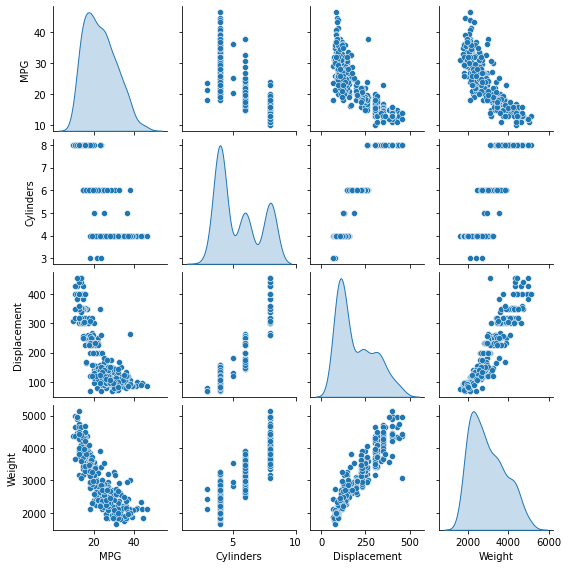

In [10]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde', height=2)
plt.show()

In [11]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

### Normalization

각 특성들은 다양한 척도와 범위를 가지고 있다. 이를 정규화해주는 것이 좋다.

그 이유는 모델은 특성에 가중치를 곱하며 학습을 하기 때문에 **모델의 출력의 규모와 기울기의 규모는 입력값에 영향을 받기 때문**이다. 물론 모델은 정규화를 하지 않고도 수렴할 수 있지만, **정규화는 학습을 훨씬 더 안정적으로 만든다.**

*'ont-hot' 특성은 정규화해도 이점이 없다.*

In [13]:
train_dataset.describe().T[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


### The Normalization layer

`tf.keras.layers.Normalization` 레이어는 모델에 정규화를 추가하는 깔끔하고 간단한 방법이다.
- 평균과 분산을 계산하고 레이어에 저장한다.
- 레이어가 호출되면 각 특성이 독립적으로 정규화된 입력 데이터를 반환한다.

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


In [15]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example: ', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Linear regression

심층 신경망 모델을 만들기 전에, 단일 변수와 다수 변수를 사용한 선형 회귀를 사용해 보자.

#### Linear regression with one variable

단일 변수 선형 회귀로 'horsepower(마력)'을 통해 'MPG'를 예측해보자.

단일 변수 선형 회귀 모델은 두 단계를 거친다.
1. `tf.keras.layers.Normalization` 레이어를 사용하여 단일 변수 정규화
2. 선형 변환$(y = mx + b)$을 적용하여 선형 레이어(`tf.keras.layers.Dense`)를 사용하여 1개의 출력 생성

입력값의 수는 `input_shape` 인수로 설정하거나, 모델이 처음 실행될 때 자동으로 설정할 수 있다.

- 먼저 단일 변수로 구성된 numpy 배열을 만들고, 'nomalization'을 인스턴스하고, 단일 변수에 적용한다.*

In [16]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [17]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


처음 10개의 데이터에 대한 학습되지 않은 모델의 예측 결과.

In [18]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 1s 613ms/step


array([[-0.7413151 ],
       [-0.4186745 ],
       [ 1.3682582 ],
       [-1.0391372 ],
       [-0.9398632 ],
       [-0.36903748],
       [-1.1135927 ],
       [-0.9398632 ],
       [-0.24494493],
       [-0.4186745 ]], dtype=float32)

`Model.compile`을 통해 학습 절차를 설정.
- **가장 중요한 인자는 `loss`와 `optimizer`이며, 이들은 최적화될 대상과 방법을 정의하기 때문이다.**

In [19]:
horsepower_model.compile(
    loss=tf.losses.MeanAbsoluteError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.05)
)

In [20]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 8.22 s
Wall time: 6.44 s


### Visualization

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803009,4.195428,95
96,3.803713,4.202314,96
97,3.804709,4.185769,97
98,3.802850,4.196649,98
99,3.802558,4.196647,99


In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

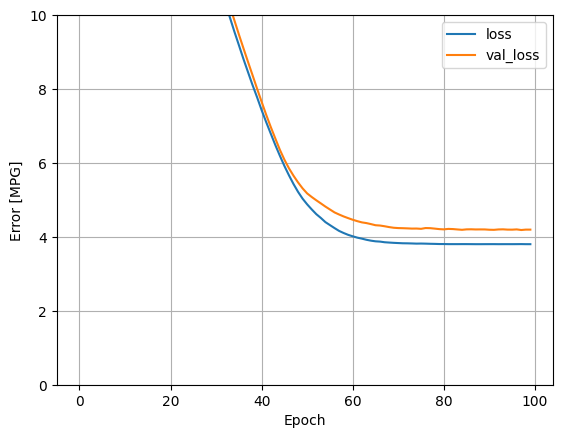

In [23]:
plot_loss(history)

In [24]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels)

3/3 [==============================] - 0s 4ms/step - loss: 3.6631
